In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pickle as pkl

In [2]:
with open('data/WMT_365_days_ended_on_2020-10-25.csv', mode='r') as file:
    reader = csv.reader(file, delimiter=",")
    wmt_data = np.array(list(reader))

wmt_data_header = wmt_data[0]
wmt_data = wmt_data[1:]
# removing blank entries
wmt_data = np.delete(wmt_data, np.where(wmt_data[:,2] == '')[0], axis=0)
print(wmt_data_header)
n_data = wmt_data.shape[0]
print(wmt_data.shape)
print('n_data:', n_data)

['' 'date' 'label' 'high' 'low' 'average' 'volume' 'notional'
 'numberOfTrades' 'marketHigh' 'marketLow' 'marketAverage' 'marketVolume'
 'marketNotional' 'marketNumberOfTrades' 'open' 'close' 'marketOpen'
 'marketClose' 'changeOverTime' 'marketChangeOverTime']
(97026, 21)
n_data: 97026


# stock price

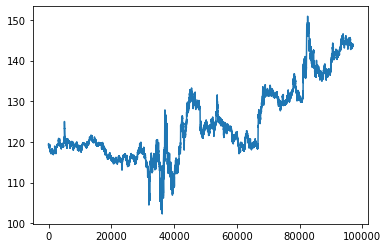

In [3]:
stock_average = wmt_data[:,11]

# replace empty value with previous known value
for i in range(n_data):
    if stock_average[i] == "":
        stock_average[i] = stock_average[i-1]
        
stock_average = stock_average.astype("float")

plt.plot(stock_average)

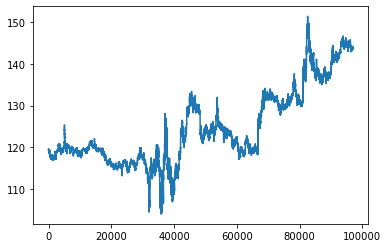

In [4]:
stock_high = wmt_data[:,9]

# replace empty value with previous known value
for i in range(n_data):
    if stock_high[i] == "":
        stock_high[i] = stock_high[i-1]
        
stock_high = stock_high.astype("float")

plt.plot(stock_high)

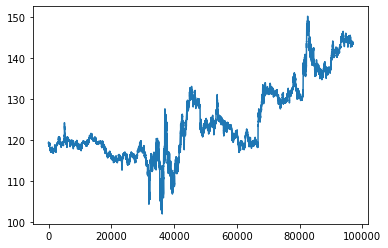

In [5]:
stock_low = wmt_data[:,10]

# replace empty value with previous known value
for i in range(n_data):
    if stock_low[i] == "":
        stock_low[i] = stock_low[i-1]
stock_low = stock_low.astype("float")

plt.plot(stock_low)

# volume

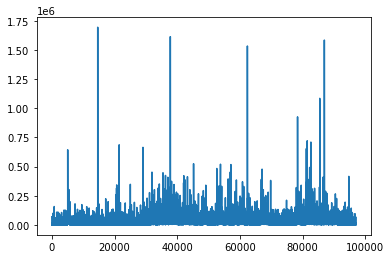

In [6]:
stock_volume = wmt_data[:,12].astype("float")
plt.plot(stock_volume)

In [ ]:
stock_number_of_trades = wmt_data[:,14].astype("float")
plt.plot(stock_number_of_trades)

# time of the date
* todo: add date of the week?

In [7]:
import datetime

In [8]:
base_time = datetime.datetime.strptime(wmt_data[0,2], '%I:%M %p')

stock_time = np.zeros((n_data))
for i in range(n_data):
    try:
        this_time = datetime.datetime.strptime(wmt_data[i,2], '%I:%M %p')
    except ValueError:
        this_time = datetime.datetime.strptime(wmt_data[i,2], '%I %p')
    stock_time[i] = (this_time - base_time).total_seconds() / 60.0

(97026,)


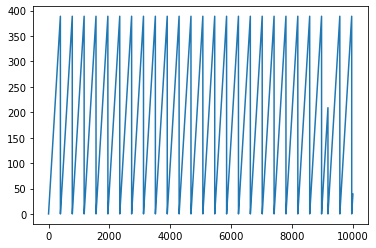

In [9]:
plt.plot(stock_time[:10000])
print(stock_time.shape)

# labeling data

In [10]:
# label as two numbers, first being buy, second being sell, -1 means error, 0 means no, 1 means yes
# exp: (0,1) means the price goes down in the future, so sell
# exp: (1,0) means the price goes up in the future, so buy
# exp: (0,0) means the price is stable in the future
# exp: (1,1) means the price fluctuates in the future

# look at the future prices between +future_1 minute and + future_2 minute, 
# if there are future price > current price * (1+thresh), than label it as buy
# if there are future price < current price * (1-thresh), than label it has sell

thresh = 0.025
future_1 = 10
future_2 = 1000

stock_labels = np.ones((n_data,2)) * -1

for i in range (n_data-future_2):
    if np.max(stock_average[i+future_1:i+future_2]) > stock_average[i]*(1+thresh):
        stock_labels[i,0] = 1
    else:
        stock_labels[i,0] = 0
        
    if np.min(stock_average[i+future_1:i+future_2]) < stock_average[i]*(1-thresh):
        stock_labels[i,1] = 1
    else:
        stock_labels[i,1] = 0

In [11]:
print('action frequency:', np.sum(stock_labels)/n_data)

action frequency: 0.39247212087481703


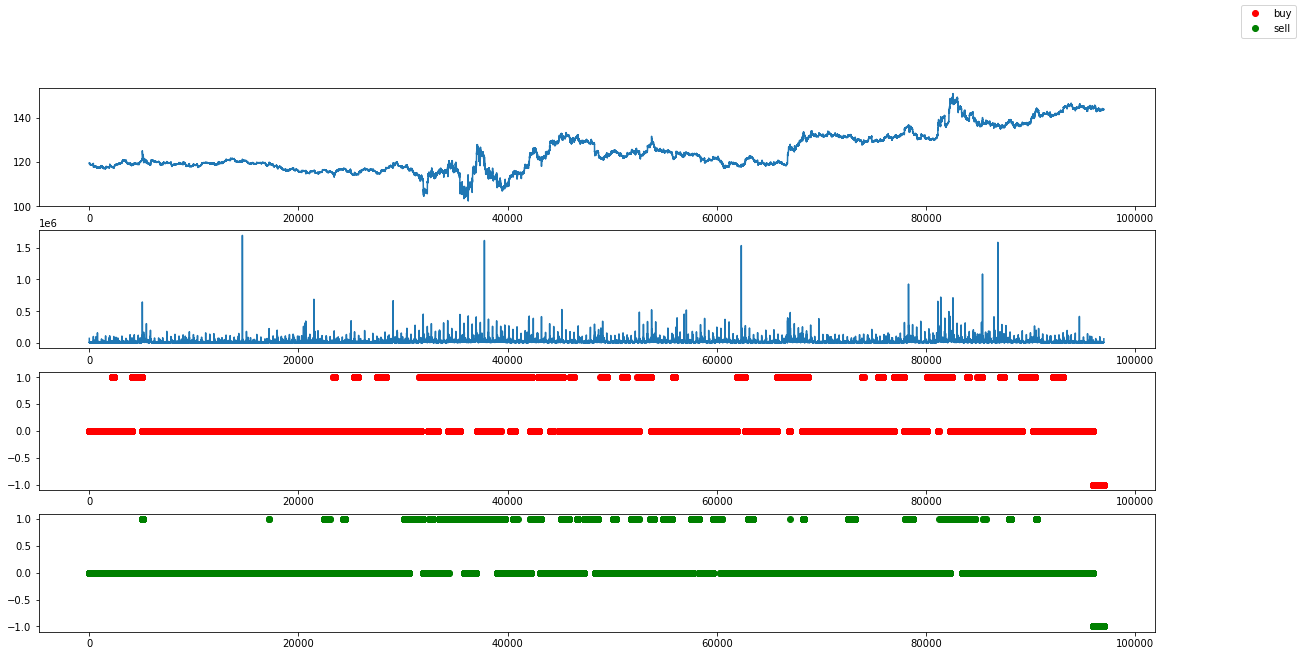

In [12]:
fig, axs = plt.subplots(4, 1, figsize=(20,10))

axs[0].plot(stock_average)
axs[1].plot(stock_volume)
axs[2].plot(stock_labels[:,0], 'o', color='red', label='buy')
axs[3].plot(stock_labels[:,1], 'o', color='green', label='sell')
fig.legend()

# split into train and val data

In [13]:
# input: the previous input_size min of data, so discard first input_size min and last future_2 min of data
input_size = 1000

x_all = []
y_all = []
for i in range(input_size,n_data-future_2):
    x = np.vstack((stock_time[i-input_size:i], 
                   stock_average[i-input_size:i], 
                   stock_high[i-input_size:i], 
                   stock_low[i-input_size:i], 
                   stock_volume[i-input_size:i])).T
    x_all.append(x)
    y_all.append(stock_labels[i])
x_all = np.array(x_all)
y_all = np.array(y_all)

print(x_all.shape, y_all.shape)

(95026, 1000, 5) (95026, 2)


In [14]:
n_example, _, n_features = x_all.shape
example_idxes = np.arange(n_example)
np.random.shuffle(example_idxes)
split_at_idx = n_data*3//4
train_idxes = example_idxes[0:split_at_idx]
val_idxes = example_idxes[split_at_idx:]
print(train_idxes.shape, val_idxes.shape)

(72769,) (22257,)


In [15]:
np.sum(y_all, axis=0)

array([22706., 17374.])

# simple ML model

In [56]:
import tensorflow as tf
import keras
from keras.models import Model, model_from_json
from keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, Reshape, Dropout
from keras.utils.vis_utils import plot_model

In [37]:
# check gpu support
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [38]:
def buildModel(input_size, n_features):
    a = Input(shape=(input_size, n_features))
    
    b = Conv1D(filters=64, kernel_size=5, activation='relu', strides=1)(a)
    b = MaxPooling1D(pool_size=4)(b)
    b = Conv1D(filters=128, kernel_size=5, activation='relu', strides=1)(b)
    b = MaxPooling1D(pool_size=4)(b)
    b = Conv1D(filters=256, kernel_size=5, activation='relu', strides=1)(b)
    b = MaxPooling1D(pool_size=4)(b)
    b = Flatten()(b)
    b = Dense(512, activation='relu')(b)
    b = Dense(64, activation='relu')(b)

    c = Dense(2, activation='sigmoid')(b)
    model = Model(inputs=a, outputs=c)
    return model

In [39]:
model = buildModel(input_size, n_features)
opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1000, 5)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 996, 64)           1664      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 249, 64)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 245, 128)          41088     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 61, 128)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 57, 256)           164096    
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 14, 256)           0   

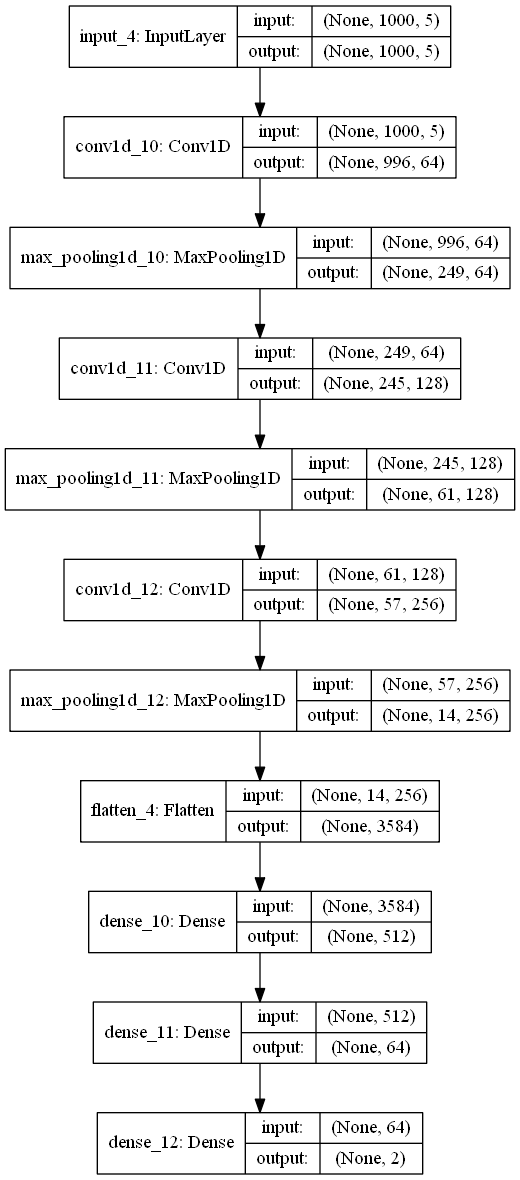

In [40]:
plot_model(model, show_shapes=True, show_layer_names=True)

# train model

In [41]:
history = model.fit(x=x_all[train_idxes], y=y_all[train_idxes], 
                    batch_size=512, epochs=100, verbose=2, 
                    validation_data=(x_all[val_idxes], y_all[val_idxes]))

Train on 72769 samples, validate on 22257 samples
Epoch 1/100
 - 14s - loss: 119.8852 - accuracy: 0.7030 - val_loss: 0.7834 - val_accuracy: 0.7703
Epoch 2/100
 - 14s - loss: 0.6322 - accuracy: 0.7851 - val_loss: 0.5516 - val_accuracy: 0.7893
Epoch 3/100
 - 14s - loss: 0.5218 - accuracy: 0.7908 - val_loss: 0.5156 - val_accuracy: 0.7905
Epoch 4/100
 - 14s - loss: 0.4927 - accuracy: 0.7926 - val_loss: 0.4690 - val_accuracy: 0.7922
Epoch 5/100
 - 14s - loss: 0.4523 - accuracy: 0.7963 - val_loss: 0.4643 - val_accuracy: 0.7960
Epoch 6/100
 - 14s - loss: 0.4273 - accuracy: 0.8004 - val_loss: 0.4234 - val_accuracy: 0.7991
Epoch 7/100
 - 14s - loss: 0.4102 - accuracy: 0.8038 - val_loss: 0.4122 - val_accuracy: 0.8013
Epoch 8/100
 - 14s - loss: 0.3945 - accuracy: 0.8074 - val_loss: 0.3891 - val_accuracy: 0.8064
Epoch 9/100
 - 14s - loss: 0.3808 - accuracy: 0.8125 - val_loss: 0.3823 - val_accuracy: 0.8111
Epoch 10/100
 - 14s - loss: 0.3642 - accuracy: 0.8186 - val_loss: 0.3661 - val_accuracy: 0.82

Epoch 86/100
 - 15s - loss: 0.0258 - accuracy: 0.9897 - val_loss: 0.0527 - val_accuracy: 0.9847
Epoch 87/100
 - 15s - loss: 0.0277 - accuracy: 0.9891 - val_loss: 0.0558 - val_accuracy: 0.9827
Epoch 88/100
 - 15s - loss: 0.0357 - accuracy: 0.9872 - val_loss: 0.0480 - val_accuracy: 0.9860
Epoch 89/100
 - 15s - loss: 0.0290 - accuracy: 0.9891 - val_loss: 0.0405 - val_accuracy: 0.9875
Epoch 90/100
 - 15s - loss: 0.0341 - accuracy: 0.9875 - val_loss: 0.0444 - val_accuracy: 0.9868
Epoch 91/100
 - 15s - loss: 0.0285 - accuracy: 0.9890 - val_loss: 0.0483 - val_accuracy: 0.9853
Epoch 92/100
 - 15s - loss: 0.0248 - accuracy: 0.9898 - val_loss: 0.0442 - val_accuracy: 0.9880
Epoch 93/100
 - 15s - loss: 0.0236 - accuracy: 0.9905 - val_loss: 0.0439 - val_accuracy: 0.9866
Epoch 94/100
 - 16s - loss: 0.0324 - accuracy: 0.9882 - val_loss: 0.0417 - val_accuracy: 0.9876
Epoch 95/100
 - 15s - loss: 0.0255 - accuracy: 0.9900 - val_loss: 0.0390 - val_accuracy: 0.9871
Epoch 96/100
 - 17s - loss: 0.0434 - acc

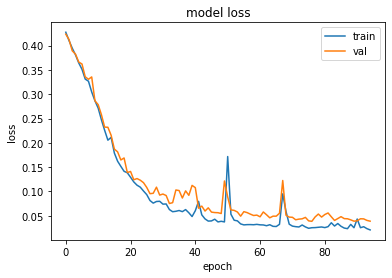

In [43]:
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

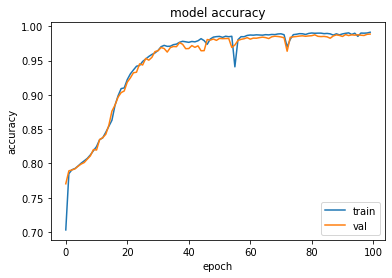

In [44]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# separte train and val

In [51]:
example_idxes = np.arange(n_example)
split_at_idx = n_data*3//4
train_idxes = example_idxes[0:split_at_idx-input_size]
val_idxes = example_idxes[split_at_idx:]

np.random.shuffle(train_idxes)
np.random.shuffle(val_idxes)
print(train_idxes.shape, val_idxes.shape)

(71769,) (22257,)


In [52]:
model = buildModel(input_size, n_features)
opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
history = model.fit(x=x_all[train_idxes], y=y_all[train_idxes], 
                    batch_size=512, epochs=50, verbose=2, 
                    validation_data=(x_all[val_idxes], y_all[val_idxes]))

Train on 71769 samples, validate on 22257 samples
Epoch 1/50
 - 17s - loss: 161.8313 - accuracy: 0.6724 - val_loss: 1.5688 - val_accuracy: 0.7239
Epoch 2/50
 - 15s - loss: 0.5971 - accuracy: 0.7810 - val_loss: 0.9768 - val_accuracy: 0.7711
Epoch 3/50
 - 16s - loss: 0.4755 - accuracy: 0.7996 - val_loss: 0.9463 - val_accuracy: 0.7808
Epoch 4/50
 - 16s - loss: 0.4494 - accuracy: 0.8060 - val_loss: 0.9766 - val_accuracy: 0.7807
Epoch 5/50
 - 16s - loss: 0.4338 - accuracy: 0.8135 - val_loss: 0.9968 - val_accuracy: 0.7503
Epoch 6/50
 - 16s - loss: 0.4154 - accuracy: 0.8206 - val_loss: 1.1753 - val_accuracy: 0.7651
Epoch 7/50
 - 15s - loss: 0.3948 - accuracy: 0.8305 - val_loss: 1.2516 - val_accuracy: 0.7720
Epoch 8/50
 - 18s - loss: 0.3782 - accuracy: 0.8377 - val_loss: 1.3428 - val_accuracy: 0.7289
Epoch 9/50
 - 16s - loss: 0.3579 - accuracy: 0.8455 - val_loss: 1.3973 - val_accuracy: 0.7453
Epoch 10/50
 - 16s - loss: 0.3360 - accuracy: 0.8539 - val_loss: 1.5201 - val_accuracy: 0.7461
Epoch 1

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [54]:
def buildModel(input_size, n_features):
    a = Input(shape=(input_size, n_features))
    
    b = Conv1D(filters=64, kernel_size=5, activation='relu', strides=1)(a)
    b = MaxPooling1D(pool_size=4)(b)
    b = Conv1D(filters=128, kernel_size=5, activation='relu', strides=1)(b)
    b = MaxPooling1D(pool_size=4)(b)
    b = Conv1D(filters=256, kernel_size=5, activation='relu', strides=1)(b)
    b = MaxPooling1D(pool_size=4)(b)
    b = Flatten()(b)
    b = Dropout(0.5)(b)
    b = Dense(512, activation='relu')(b)
    b = Dense(64, activation='relu')(b)

    c = Dense(2, activation='sigmoid')(b)
    model = Model(inputs=a, outputs=c)
    return model

In [57]:
model = buildModel(input_size, n_features)
opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_all[train_idxes], y=y_all[train_idxes], 
                    batch_size=512, epochs=20, verbose=2, 
                    validation_data=(x_all[val_idxes], y_all[val_idxes]))

Train on 71769 samples, validate on 22257 samples
Epoch 1/20
 - 16s - loss: 106.9673 - accuracy: 0.7447 - val_loss: 0.6598 - val_accuracy: 0.7974
Epoch 2/20
 - 15s - loss: 0.6553 - accuracy: 0.7846 - val_loss: 0.6266 - val_accuracy: 0.7974
Epoch 3/20
 - 15s - loss: 0.6211 - accuracy: 0.7849 - val_loss: 0.5996 - val_accuracy: 0.7974
Epoch 4/20
 - 15s - loss: 0.5964 - accuracy: 0.7850 - val_loss: 0.5779 - val_accuracy: 0.7974
Epoch 5/20
 - 15s - loss: 0.5761 - accuracy: 0.7851 - val_loss: 0.5604 - val_accuracy: 0.7974
Epoch 6/20
 - 14s - loss: 0.5623 - accuracy: 0.7851 - val_loss: 0.5466 - val_accuracy: 0.7974
Epoch 7/20
 - 14s - loss: 0.5525 - accuracy: 0.7850 - val_loss: 0.5356 - val_accuracy: 0.7974
Epoch 8/20
 - 14s - loss: 0.5435 - accuracy: 0.7851 - val_loss: 0.5270 - val_accuracy: 0.7974
Epoch 9/20
 - 14s - loss: 0.5361 - accuracy: 0.7851 - val_loss: 0.5204 - val_accuracy: 0.7974
Epoch 10/20
 - 15s - loss: 0.5309 - accuracy: 0.7851 - val_loss: 0.5152 - val_accuracy: 0.7974
Epoch 1

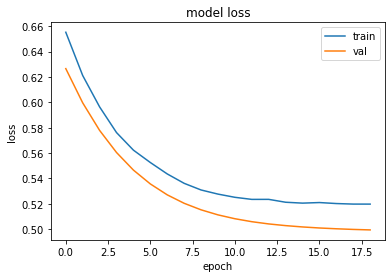

In [58]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# simulate data

In [59]:
init_stock_position = 0
init_cash = 10000

In [62]:
# strategy 1: buy all at time 0, sell all at the end
stock_position = init_cash / stock_average[0]
end_stock_value = stock_average[-future_2] * stock_position

print('Percent return:', end_stock_value / init_cash * 100 - 100)

Percent return: 21.125012578405375


In [67]:
# strategy 2: buy half, and then randomly buy and sell
percent_returns = []
for t in range(20):
    stock_position = init_cash / stock_average[0] / 2
    cash = init_cash / 2
    for i in range(n_data-future_2):
        action = np.random.randint(0,3)
        if action == 1:
            # buy one if you can
            if stock_average[0] < cash:
                stock_position += 1
                cash -= stock_average[i]
        elif action == 2:
            # sell one if you can
            if stock_position > 0:
                stock_position -= 1
                cash += stock_average[i]

    end_stock_value = stock_average[-future_2] * stock_position + cash
    print('Percent return:', end_stock_value / init_cash * 100 - 100)
    percent_returns.append(end_stock_value / init_cash * 100 - 100)
print('Average percent return:', np.average(percent_returns))

Percent return: 16.446576289202852
Percent return: 14.885886289202972
Percent return: 13.542446289201578
Percent return: 2.991916289202919
Percent return: 17.540986289202593
Percent return: 10.458146289204052
Percent return: 16.817656289203086
Percent return: 2.562406289203011
Percent return: 11.031346289201764
Percent return: 24.210676289201544
Percent return: 18.568336289203202
Percent return: 13.109716289201273
Percent return: 7.086936289202271
Percent return: 10.096216289202758
Percent return: 14.062176289201986
Percent return: 9.74334628920272
Percent return: 14.530656289200977
Percent return: 9.520246289202802
Percent return: 5.538246289203215
Percent return: 19.250556289202294
Average percent return: 12.599723789202494


In [71]:
# strategy 3: using the model, buy/sell as much as you can
stock_position = init_cash / stock_average[0] / 2
cash = init_cash / 2

actions = model.predict(x_all)

for i in range(input_size,n_data-future_2):
    if actions[i-input_size,0] > 0.5 and actions[i-input_size,1] < 0.5 and cash > 0:
        # buy as much as you can
        print('bought', cash / stock_average[i], 'at', stock_average[i])
        stock_position += cash / stock_average[i]
        cash = 0
    elif actions[i-input_size,0] < 0.5 and actions[i-input_size,1] > 0.5 and stock_position > 0:
        # sell as much as you can
        print('sold', stock_position, 'at', stock_average[i])
        cash += stock_average[i] * stock_position
        stock_position = 0

end_stock_value = stock_average[future_2] * stock_position + cash
print('Percent return:', end_stock_value / init_cash * input_size - input_size)
percent_returns.append(end_stock_value / init_cash * input_size - input_size)

Percent return: -7.622513668533884


In [76]:
stock_position

41.92801797873411

In [77]:
cash

5000.0

In [78]:
actions.shape

(95026, 2)

In [86]:
np.where(actions[:,0] ==0.23324049)[0].shape

(95025,)

(0.2325, 0.234)

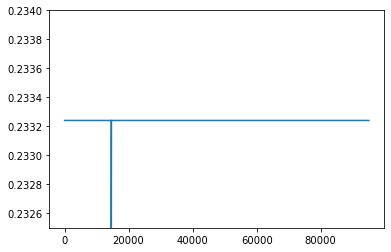

In [82]:
plt.plot(actions[:,0])
plt.ylim([0.2325, 0.234])

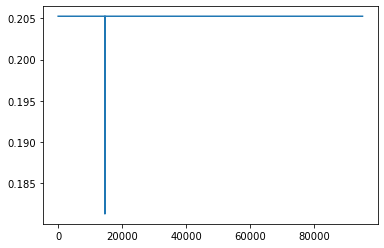

In [75]:
plt.plot(actions[:,1])

In [ ]:
# strategy 4: using the model, buy/sell 1
stock_position = init_cash / stock_average[0] / 2
cash = init_cash / 2

actions = model.predict(x_all)

for i in range(input_size,n_data-future_2):
    if actions[i-input_size,0] > 0.5 and actions[i-input_size,1] < 0.5 and cash > stock_price[i,0]:
        # buy 1
        print('bought 1 at', stock_price[i,0])  
        stock_position += 1
        cash -= stock_price[i,0]
    elif actions[i-input_size,0] < 0.5 and actions[i-input_size,1] > 0.5 and stock_position > 1:
        # sell 1
        print('sold 1 at', stock_price[i,0])
        stock_position -= 1
        cash += stock_price[i,0]

end_stock_value = stock_price[future_2,0] * stock_position + cash
print('Percent return:', end_stock_value / init_cash * input_size - input_size)
percent_returns.append(end_stock_value / init_cash * input_size - input_size)